In [1]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Flatten
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
from keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers.convolutional import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
from keras.layers import Activation, Conv2D, Dropout
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D,AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling1D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

In [ ]:
img_rows=224
num_classes=6
img_cols=224
num_channel=3

In [ ]:
import splitfolders
# splitfolders.ratio('/content/drive/MyDrive/Preprocessing_frames/UCF-ARG Data Set/3 FPS', output="output128", seed=1337, ratio=(0.6,0.2,0.2))
splitfolders.ratio('/content/drive/MyDrive/Galaxy Zoo DECALS data', output="output202", seed=1337, ratio=(0.7,0.15,0.15))

Copying files: 14693 files [03:01, 80.87 files/s] 


In [ ]:

TRAINING_DIR = "/content/output202/train" ## interpolated
#TRAINING_DIR = "/content/output202/train"

# train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True

train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=8,
                                                    class_mode='categorical',
                                                    target_size=(img_rows, img_cols),shuffle=True)

Found 10280 images belonging to 7 classes.


In [ ]:
VALIDATION_DIR = '/content/output202/val' ## interpolated
#VALIDATION_DIR = '/content/output202/val'

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=8,
                                                              class_mode='categorical',
                                                              target_size=(img_rows, img_cols)
                                                             )

Found 2201 images belonging to 7 classes.


## ECA module Based CNN Model

In [86]:
import tensorflow as tf
from tensorflow import keras

input_shape=(224,224,3)
##mini_exceptin

img_input = Input(input_shape)
x = SeparableConv2D(32, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(img_input)
x = BatchNormalization()(x)
x_offset = Activation('relu')(x)


x_offset


<KerasTensor: shape=(None, 224, 224, 32) dtype=float32 (created by layer 'activation_34')>

## Block 1

In [87]:
# module 1
residual = SeparableConv2D(32, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
residual = BatchNormalization()(residual)
residual=Activation('relu')(residual)



residual.shape

TensorShape([None, 224, 224, 32])

In [88]:
residual1 = SeparableConv2D(32, (5, 5), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
residual1 = BatchNormalization()(residual1)
residual1=Activation('relu')(residual1)



residual1.shape

TensorShape([None, 224, 224, 32])

In [89]:
# module 1
residual2 = SeparableConv2D(32, (7, 7), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
residual2 = BatchNormalization()(residual2)
residual2=Activation('relu')(residual2)

ECA Attention Module

In [90]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling2D, Reshape, Multiply

In [91]:
def eca_module(x, k_size=5):
    squeeze = GlobalAveragePooling2D()(x)
    attn = Conv1D(filters=1,
                            kernel_size=k_size,
                            padding='same',
                            kernel_initializer='he_normal',
                            use_bias=False)(tf.expand_dims(squeeze, axis=1))
    attn = tf.math.sigmoid(tf.expand_dims(tf.transpose(attn, [0, 2, 1]), axis=3))
    scale = x * attn
    return scale

In [92]:

channel_attention_map=eca_module(x_offset)
channel_attention_map

<KerasTensor: shape=(None, 224, 224, 32) dtype=float32 (created by layer 'tf.math.multiply_8')>

In [93]:
x11 = layers.add([residual1,residual,residual2,channel_attention_map])
x11.shape

TensorShape([None, 224, 224, 32])

## Dilation Convolution Layer

In [94]:
x =  SeparableConv2D(64, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x11)
x = BatchNormalization()(x)
x_offset = Activation('relu')(x)
x_offset = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x_offset)

x_offset

<KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'max_pooling2d_4')>

## Block 2

In [95]:
# module 1
residual = SeparableConv2D(64, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu',kernel_regularizer='l1', use_bias=False)(x_offset)
residual = BatchNormalization()(residual)
residual=Activation('relu')(residual)



residual.shape

TensorShape([None, 112, 112, 64])

In [96]:
residual1 = SeparableConv2D(64, (5, 5), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu',kernel_regularizer='l1', use_bias=False)(x_offset)
residual1 = BatchNormalization()(residual1)
residual2=Activation('relu')(residual1)



residual2.shape

TensorShape([None, 112, 112, 64])

In [97]:
# module 1
residual3 = SeparableConv2D(64, (7, 7), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation='relu',kernel_regularizer='l1', use_bias=False)(x_offset)
residual3 = BatchNormalization()(residual3)
residual3=Activation('relu')(residual3)

ECA Attention Module

In [98]:
def eca_module(x, k_size=5):
    squeeze = GlobalAveragePooling2D()(x)
    attn = Conv1D(filters=1,
                            kernel_size=k_size,
                            padding='same',
                            kernel_initializer='he_normal',
                            use_bias=False)(tf.expand_dims(squeeze, axis=1))
    attn = tf.math.sigmoid(tf.expand_dims(tf.transpose(attn, [0, 2, 1]), axis=3))
    scale = x * attn
    return scale

In [99]:

channel_attention_map=eca_module(x_offset)
channel_attention_map

<KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'tf.math.multiply_9')>

In [100]:
x11 = layers.add([residual2,residual,channel_attention_map,residual3])
x11.shape

TensorShape([None, 112, 112, 64])

## Dilation Convolution Layer

In [101]:
x =  SeparableConv2D(128, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x11)
x = BatchNormalization()(x)
x_offset = Activation('relu')(x)
x_offset = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x_offset)

x_offset

<KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'max_pooling2d_5')>




## Block 3

In [102]:
# module 1
residual = SeparableConv2D(128, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
residual = BatchNormalization()(residual)
residual=Activation('relu')(residual)



residual.shape

TensorShape([None, 56, 56, 128])

In [103]:
# module 1
residual1 = SeparableConv2D(128, (5, 5), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
residual1 = BatchNormalization()(residual1)
residual12=Activation('relu')(residual1)

In [104]:
residual1 = SeparableConv2D(128, (5, 5), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
residual1 = BatchNormalization()(residual1)
residual13=Activation('relu')(residual1)


ECA Attention Module

In [105]:
def eca_module(x, k_size=5):
    squeeze = GlobalAveragePooling2D()(x)
    attn = Conv1D(filters=1,
                            kernel_size=k_size,
                            padding='same',
                            kernel_initializer='he_normal',
                            use_bias=False)(tf.expand_dims(squeeze, axis=1))
    attn = tf.math.sigmoid(tf.expand_dims(tf.transpose(attn, [0, 2, 1]), axis=3))
    scale = x * attn
    return scale

In [106]:

channel_attention_map=eca_module(x_offset)
channel_attention_map

<KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'tf.math.multiply_10')>

In [107]:

x11 = layers.add([residual12,residual,residual13,channel_attention_map])
x11.shape

TensorShape([None, 56, 56, 128])

## Dilation Convolution Layer

In [108]:
x =  SeparableConv2D(256, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x11)
x = BatchNormalization()(x)
x_offset = Activation('relu')(x)

x_offset

<KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'activation_46')>




## Block 4

In [109]:
# # module 1
# residual = SeparableConv2D(256, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
# residual = BatchNormalization()(residual)
# residual=Activation('relu')(residual)



# residual.shape

In [110]:
# # module 1
# residual1 = SeparableConv2D(256, (5, 5), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
# residual1 = BatchNormalization()(residual1)
# residual1=Activation('relu')(residual1)

In [111]:
# residual1 = SeparableConv2D(256, (7, 7), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x_offset)
# residual1 = BatchNormalization()(residual1)
# residual3=Activation('relu')(residual1)

ECA Attention Module

In [112]:
# def eca_module(x, k_size=5):
#     squeeze = GlobalAveragePooling2D()(x)
#     attn = Conv1D(filters=1,
#                             kernel_size=k_size,
#                             padding='same',
#                             kernel_initializer='he_normal',
#                             use_bias=False)(tf.expand_dims(squeeze, axis=1))
#     attn = tf.math.sigmoid(tf.expand_dims(tf.transpose(attn, [0, 2, 1]), axis=3))
#     scale = x * attn
#     return scale

In [113]:

# channel_attention_map=eca_module(x_offset)
# channel_attention_map

In [114]:
# x11 = layers.add([residual1,residual,residual3,channel_attention_map])
# x11.shape

In [115]:

# x =  SeparableConv2D(256, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",kernel_regularizer='l1', use_bias=False)(x11)
# x = BatchNormalization()(x)
# x_offset = Activation('relu')(x)

# x_offset

In [116]:
#x15=GlobalAveragePooling2D()(x11)
#x15
x15=GlobalAveragePooling2D()(x_offset)
x15

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'global_average_pooling2d_13')>

In [117]:


# pip install dropconnect-tensorflow

In [118]:
# from dropconnect_tensorflow import DropConnectDense

In [119]:
# Dropout layer
# x=DropConnectDense(units=256, prob=0.4, activation="relu", use_bias=True)(x15)
x = tf.keras.layers.Dropout(0.3)(x15)

In [120]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, concatenate



In [121]:
# x = keras.layers.GlobalAveragePooling2D()(x33)
output=Dense(7, activation='softmax')(x)
output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [122]:
model = Model(img_input, output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 separable_conv2d_34 (Separ  (None, 224, 224, 32)         123       ['input_3[0][0]']             
 ableConv2D)                                                                                      
                                                                                                  
 batch_normalization_34 (Ba  (None, 224, 224, 32)         128       ['separable_conv2d_34[0][0]'] 
 tchNormalization)                                                                                
                                                                                            

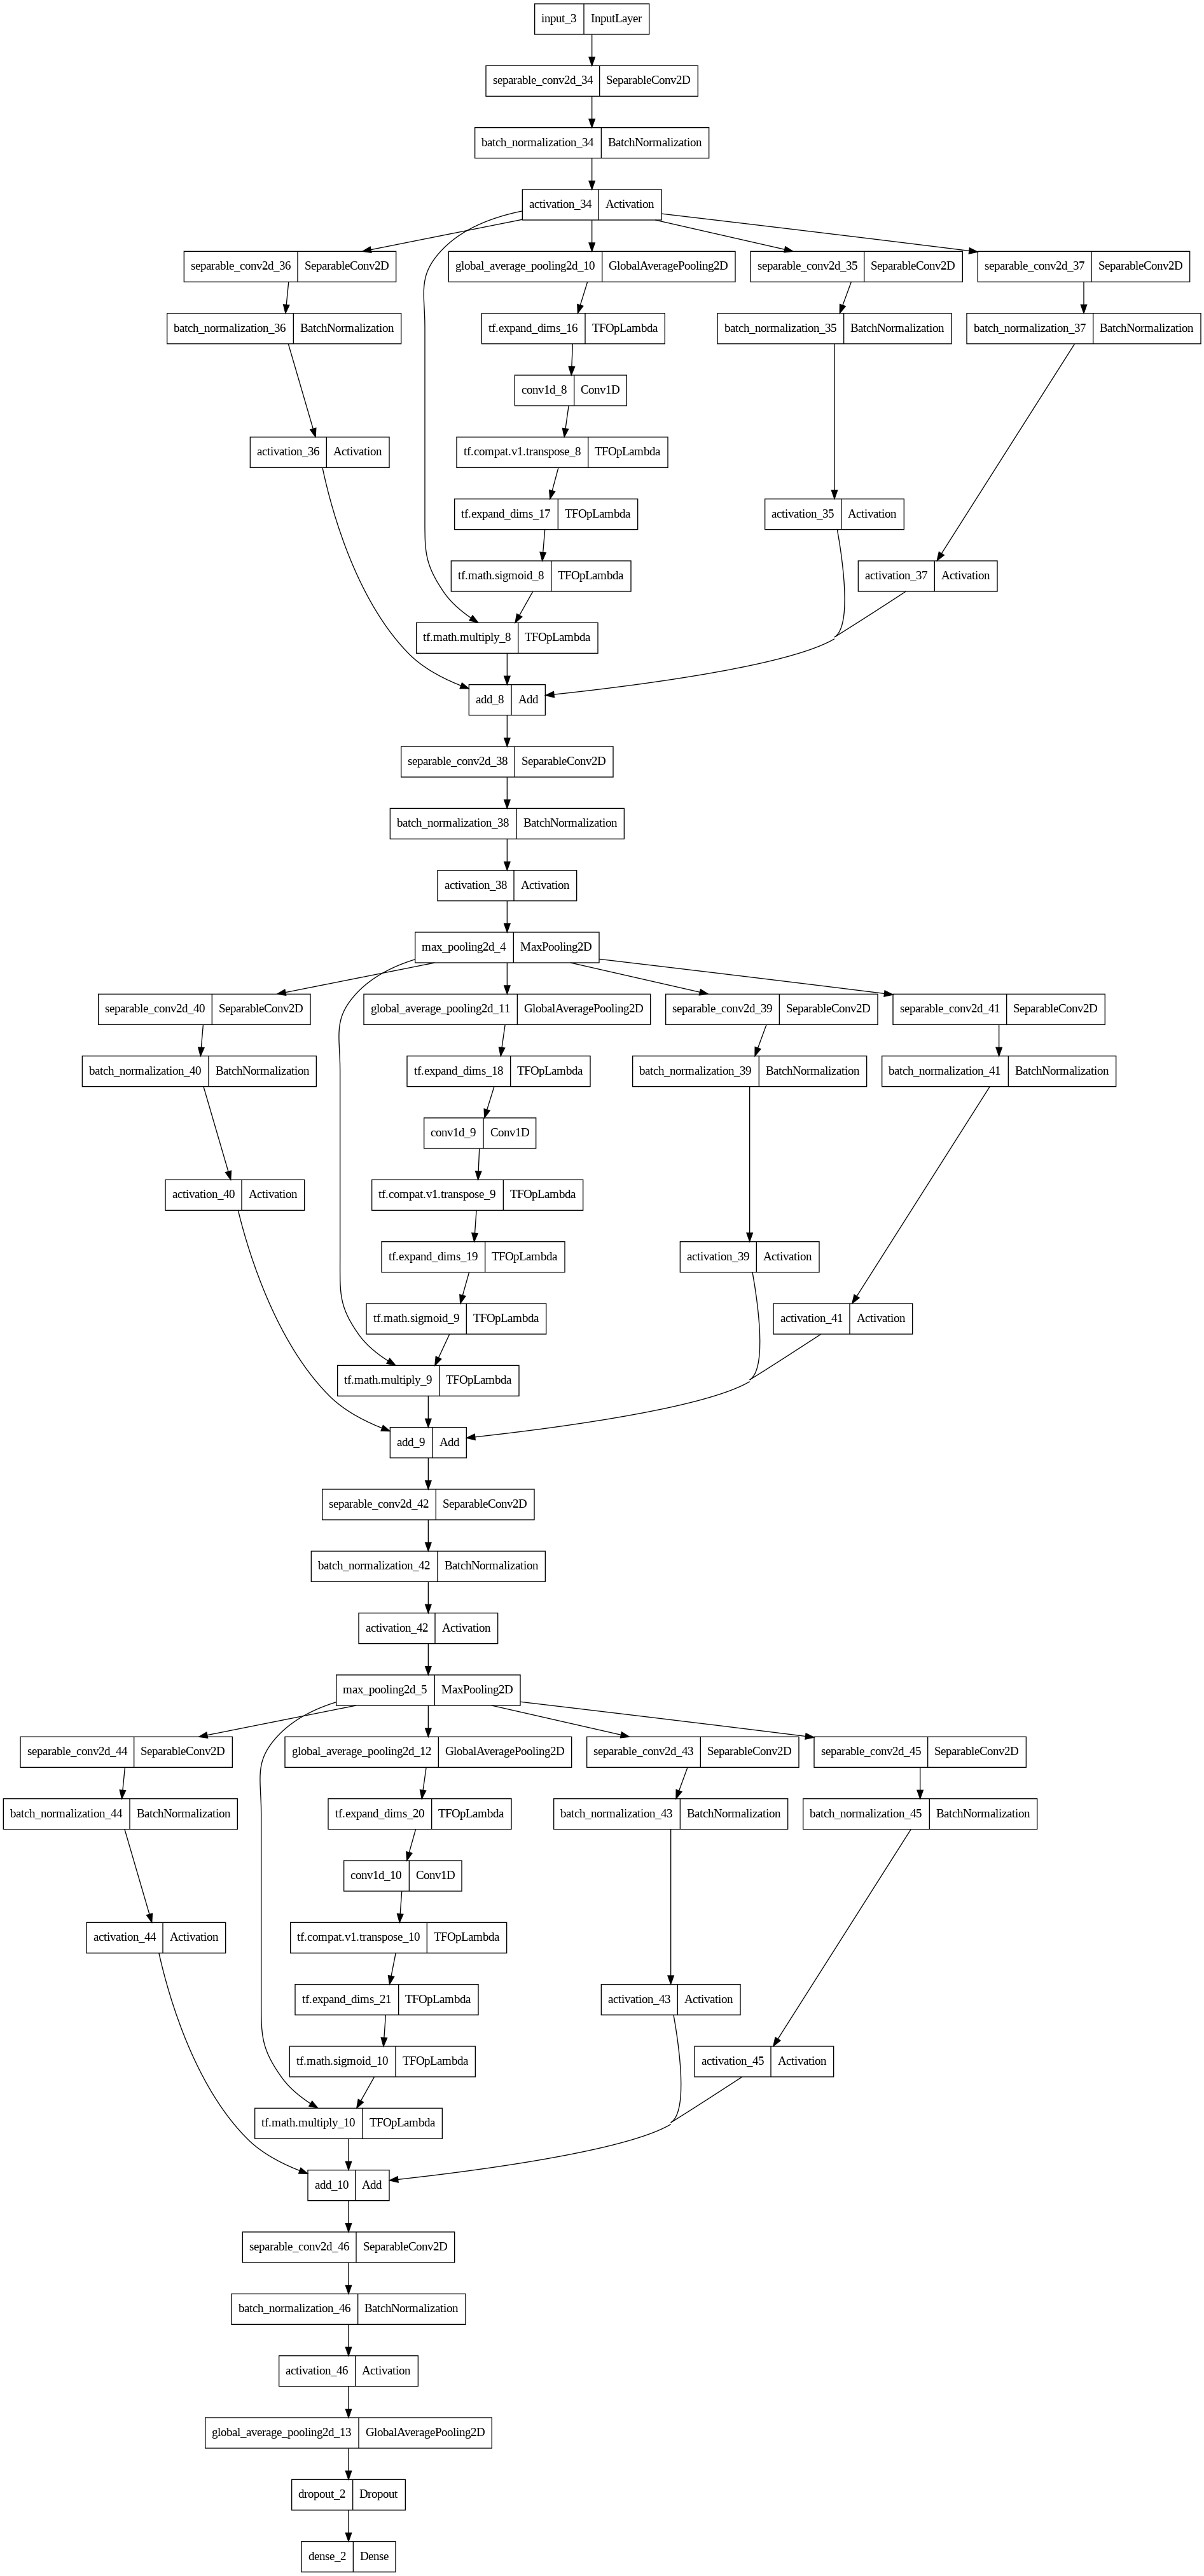

In [123]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [38]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=["accuracy"])

In [39]:
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.01
  if epoch > 10:
    learning_rate = 0.002
  if epoch > 25:
    learning_rate = 0.001
  if epoch > 35:
    learning_rate = 0.0001

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

In [40]:
from tensorflow import keras

In [ ]:
from tensorflow import keras
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:

model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
#np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

True

In [ ]:
#history = model.fit(train_generator,validation_data = validation_generator,steps_per_epoch=3482//8,validation_steps=745//8,epochs=100,batch_size=16, verbose=1)
history = model.fit(train_generator,validation_data = validation_generator,epochs=35,batch_size=32, verbose=1,callbacks=[ lr_callback])


Epoch 1/35
1285/1285 [==============================] - 201s 151ms/step - loss: 1.3971 - accuracy: 0.4740 - val_loss: 1.1762 - val_accuracy: 0.5661 - lr: 0.0100
Epoch 2/35
1285/1285 [==============================] - 172s 133ms/step - loss: 1.2048 - accuracy: 0.5707 - val_loss: 1.9538 - val_accuracy: 0.4961 - lr: 0.0100
Epoch 3/35
1285/1285 [==============================] - 171s 133ms/step - loss: 1.0589 - accuracy: 0.6304 - val_loss: 1.5725 - val_accuracy: 0.4098 - lr: 0.0100
Epoch 4/35
1285/1285 [==============================] - 185s 144ms/step - loss: 0.9840 - accuracy: 0.6521 - val_loss: 2.0183 - val_accuracy: 0.1772 - lr: 0.0100
Epoch 5/35
1285/1285 [==============================] - 168s 131ms/step - loss: 0.8852 - accuracy: 0.6879 - val_loss: 0.9579 - val_accuracy: 0.6701 - lr: 0.0100
Epoch 6/35
1285/1285 [==============================] - 168s 131ms/step - loss: 0.8312 - accuracy: 0.7080 - val_loss: 1.2206 - val_accuracy: 0.6070 - lr: 0.0100
Epoch 7/35
1285/1285 [============

In [ ]:

model.save('/content/drive/MyDrive/galaxyzooDECLAS_2-path-2block_adam_CNN_0.7_0.15_0.15_224x224xx3_30.h5')

In [ ]:
from tensorflow.keras.models import load_model
# new_model = load_model('/content/drive/MyDrive/galaxyzoo2_3block_adam_with_ECA_256x256x3_k=5_0.7_0.15_0.15.h5')
model = load_model('/content/drive/MyDrive/galaxyzoo2_2-path-4block_k=3_adam_with_ECA_0.7_0.15_0.15_224x224xx3_30.h5')


In [ ]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
print('TensorFlow:', tf.__version__)



forward_pass = tf.function(
    model.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops = graph_info.total_float_ops // 2
print('Flops: {:,}'.format(flops))

In [ ]:
img_width=128; img_height=128

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
fig2 = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
img_width=224; img_height=224

In [ ]:
## Test Performance on Test Data
import pandas as pd
import numpy as np
# from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import load_img,img_to_array
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a = a / 255
    return a

In [ ]:
test_classes = []
main = '/content/output202/test'
test_image = []
for classes in os.listdir(main):
    path_1 = main + '/' + str(classes)
    print(classes)
    for images in os.listdir(path_1):
        test_classes.append(classes)
        test_image.append(str(images))
print(len(test_classes))
print(len(test_image))

In [ ]:
img_height=224
img_width=224



In [ ]:
main = '/content/output202/test'
test_preprocessed_images = []
for classes in os.listdir(main):
    path_1 = main + '/' + str(classes)
    for images in os.listdir(path_1):
      path_2 = path_1 + '/' + str(images)
      processed = preprocess_image(path_2)
      test_preprocessed_images.append(processed)

test_preprocessed_images = np.vstack(test_preprocessed_images)
np.save('/content/test_preproc_CNN.npy', test_preprocessed_images)

In [ ]:
array = model.predict(test_preprocessed_images, batch_size=1, verbose=1)
answer = np.argmax(array, axis=1)
print(answer)

In [ ]:
y_true = test_classes
y_pred = array
print(y_true)

In [ ]:



## Galaxy Z00 2 Dataset
for x in y_true:

  if x==str('0 completely_round'):

    index = y_true.index(x)
    y_true[index] = 0
  if x==str('1 inbetween'):

    index = y_true.index(x)
    y_true[index] = 1
  if x==str('2 cigarshaped'):

    index = y_true.index(x)
    y_true[index] = 2
  if x==str('3 lenticular'):

    index = y_true.index(x)
    y_true[index] = 3
  if x==str('4 barred_spiral'):

    index = y_true.index(x)
    y_true[index] = 4
  if x==str('5 unbarred_spiral'):

    index = y_true.index(x)
    y_true[index] = 5
  if x==str('6 irregular'):

    index = y_true.index(x)
    y_true[index] = 6
print(y_true)

 ## Galaxy Zoo DECALS data
for x in y_true:

   if x==str('Cigar Round Smooth'):

     index = y_true.index(x)
     y_true[index] = 0
   if x==str('Edgeon-with Bulge'):

     index = y_true.index(x)
     y_true[index] = 1
   if x==str('Edgeon-without Bulge'):
     index = y_true.index(x)
     y_true[index] = 2
   if x==str('In-between Round Smooth'):

     index = y_true.index(x)
     y_true[index] = 3
   if x==str('Merging'):

     index = y_true.index(x)
     y_true[index] = 4
   if x==str('Round Smooth'):

     index = y_true.index(x)
     y_true[index] = 5
   if x==str('Spiral'):

     index = y_true.index(x)
     y_true[index] = 6
print(y_true)



In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, answer)
conf_mat

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
classes = os.listdir('/content/output202/test')
print(classes)

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(8,8))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion matrix, without normalization')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true, answer,digits = 4))